## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [11]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)



a. Reading in the dataset and take a look at the top few rows here:

In [12]:
df = pd.read_csv('ab_data.csv')#reading the data
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [13]:
#number of rows
df.shape[0]

294478

The number of unique users in the dataset.

In [14]:
#number of unique users
df.user_id.nunique()

290584

The proportion of users converted.

In [15]:
#total conversion rate
df.converted.mean()


0.11965919355605512

 The number of times the `new_page` and `treatment` don't line up.

In [16]:
#number of not aligned values
no_line_up_1 = df.query('group == "treatment"& landing_page != "new_page"').shape[0] 
no_line_up_2 = df.query('group != "treatment"& landing_page == "new_page"').shape[0] 
total_nolineup = no_line_up_1 + no_line_up_2
print(total_nolineup)

3893


 Do any of the rows have missing values?

In [17]:
#calculating missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.



In [18]:
#dropping not aligned values in group and landing page columns
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)



In [19]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

 How many unique **user_id**s are in **df2**?

In [20]:
#unique user ids in df2
df2.user_id.nunique()

290584

 There is one **user_id** repeated in **df2**.  What is it?

In [21]:
# the duplicated user_id
df2[df2.duplicated('user_id')][['user_id']]

,user_id
2893,773192


c. What is the row information for the repeat **user_id**? 

In [22]:
#row information of the repeat user_id
duplicated_user = df2[df2.duplicated('user_id')]
duplicated_user

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


 Removing **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [23]:
#dropping one of the duplicated rows
df2.drop(index = duplicated_user.index , inplace  = True)


 What is the probability of an individual converting regardless of the page they receive?

In [24]:
# conversion rate regardless of the page they receive
df2.converted.mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [25]:
#calculating the conversion rate with condition of beign from the control group
treatment_prob = df2.query('group == "control" ')['converted'].mean()
treatment_prob

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [26]:
#calculating the conversion rate with condition of beign from the treatment group
control_prob = df2.query('group == "treatment" ')['converted'].mean()
control_prob

0.11880806551510564

What is the probability that an individual received the new page?

In [27]:
#calculating the probability that an individual received the new page
(df2.query('landing_page == "new_page"')['user_id'].count())/df2.user_id.count()

0.5000619442226688

**conclusion : the coversion rate for both groups is very close , i think there is no sufficient evidence to say that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Noticing that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  we can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_0$**`null : Pold - Pnew >= 0`
, **$H_1$**`alternative : Pold - Pnew < 0`

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Using a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Using the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - we are going to work through the problems below to complete this problem. 

a. What is the **convert rate** for $p_{new}$ under the null? 

In [28]:
#calculating the convertion rate under the null which is the converted rate in ab_data.csv regardless of the page.
Pnew = df2.converted.mean()

Pnew

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [29]:
#calculating the convertion rate under the null which is the converted rate in ab_data.csv regardless of the page.

Pold = df2.converted.mean()

Pold

0.11959708724499628

c. What is $n_{new}$?

In [30]:
#calculating the number of users viewed the new page
n_new = df2.query('group == "treatment" ').user_id.count()
n_new

145310

d. What is $n_{old}$?

In [31]:
#calculating the number of users viewed the old page
n_old = df2.query('group == "control" ').user_id.count()
n_old

145274

e. Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [32]:
#Simulating 𝑛𝑛𝑒𝑤 transactions with a convert rate of 𝑝𝑛𝑒𝑤 under the null
new_page_converted = np.random.binomial(2, Pnew,n_new)
new_page_converted.mean()

0.23974950106668502

f. Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [33]:
#Simulating 𝑛𝑜𝑙𝑑 transactions with a convert rate of 𝑝𝑜𝑙𝑑 under the null
old_page_converted = np.random.binomial(2, Pold , n_old)
old_page_converted.mean()

0.2392788799096879

g. Finding $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [34]:
#calculating 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑
diffs_under_null = new_page_converted.mean() - old_page_converted.mean()
diffs_under_null

0.00047062115699711415

h. Simulating 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Storing all 10,000 values in a numpy array called **p_diffs**.

In [35]:
#sampling distribution under the null
p_diffs = [] #creating p_diffs to store all 10000 values
for _ in range(10000) :
    
    # Simulating 𝑛𝑛𝑒𝑤 transactions with a convert rate of 𝑝𝑛𝑒𝑤 under the null
     new_converted_simulation = np.random.binomial(n_new, Pnew, 10000)/n_new
   
    # Simulating 𝑛𝑜𝑙𝑑 transactions with a convert rate of 𝑝𝑜𝑙𝑑 under the null
     old_converted_simulation = np.random.binomial(n_old, Pold, 10000)/n_old   
        
    #storing the difference in p_diffs
     p_diffs = new_converted_simulation - old_converted_simulation



i. Ploting a histogram of the **p_diffs**.  Does this plot look like what we expected?

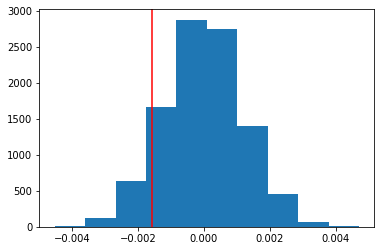

In [36]:
plt.hist(p_diffs); #plotting a histogram of p_diffs

#calcualting the observed difference .
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()

plt.axvline(obs_diff, c='red'); #plotting the observed difference value

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [37]:

(p_diffs > obs_diff ).mean() #calculating the p-value

0.9033

**conclusion :** 
**we just calculated the p-value, it was much larger than the threshold alpha value -0.05- which suggests that we shouldn't reject the null hypothesis, and we should stay with it, that means that on average there is no difference in performance between the new page and the old one .** 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Filling in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Letting `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [38]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("landing_page == 'old_page' & converted == 1").shape[0]

# number of conversions with the new_page
convert_new = df2.query("landing_page == 'new_page' & converted == 1").shape[0]

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page" ').user_id.nunique()

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page" ').user_id.nunique()

m. Now using `stats.proportions_ztest` to compute your test statistic and p-value.

In [39]:
#performing z-test
z_score , p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
z_score , p_value #displaying the z score and p value

(1.3109241984234394, 0.9050583127590245)

**conclusion : in this case $Z_{score}$ < $Z_{\alpha}$.** which means we can't reject the null also the p-value supports that, and they agree with findings in parts **j.** and **k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion,we should be performing Logistic regression because we have only two responses

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Adding an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [40]:
df2['intercept']=1 #creating the intercept
df2[['ab_page0','ab_page']] = pd.get_dummies(df2['group']) #getting the dummy variables
df2.drop('ab_page0',axis = 1 , inplace = True) #drop the extra column
df2.head() #display first few rows

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Using **statsmodels** to import our regression model.  Instantiate the model, and fit the model using the two columns we created in part **b.** to predict whether or not an individual converts.

In [41]:
logistic_model = sm.Logit(df2['converted'],df2[['intercept','ab_page']]) #instantiating the model
results = logistic_model.fit() #fitting the model

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Providing the summary of your model below, 

In [42]:
results.summary() #displaying summries

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 Apr 2022   Pseudo R-squ.:               8.077e-06
Time:                        22:12:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**conclusion : here P-value > α: The association between the type of landing_page and conversion rate is not statistically significant .**

**adding interaction terms is not the best way in interpreting the results**

g. Now along with testing if the conversion rate changes for different pages, also adding an effect based on which country a user lives. we will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.   

Does it appear that country had an impact on conversion? 

In [43]:
countries_df = pd.read_csv('./countries.csv') #reading and creating countries data
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner') #joining with df2
df_new.head() #displaying first few rows

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [44]:
### Create the necessary dummy variables
df_new['intercept'] = 1 #creating the intercept 
df_new[['country_uk','country_us','country_ca']]= pd.get_dummies(df_new['country'])

In [45]:
df_new.drop('country_ca',axis = 1 , inplace = True) #dropping country_ca column
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,country_uk,country_us
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [46]:
#instantiating and fitting the model

log_model = sm.Logit(df_new['converted'],df_new[['intercept','country_uk','country_us']])
output = log_model.fit() 

output.summary()#displaying summries

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 17 Apr 2022   Pseudo R-squ.:               1.521e-05
Time:                        22:12:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
country_uk    -0.0408      0.027     -1.518      0.129      -0.093       0.012
country_us     0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

### conclusion : since p-value > α we can say that there is no association between only - country and the conversion rate , saying that country may not be affecting conversion rate

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Creating the necessary additional columns, and fit the new model.  

Providing the summary results, and our conclusions based on the results.

In [47]:
### Fit Your Linear Model And Obtain the Results
#maping ab_page and country columns so we can get interaction column with useful numbers

maping_ab_page = {0 : 1 , 1 : 2} #mapping ab_page
df_new.ab_page = df_new.ab_page.map(maping_ab_page)#mapping ab_page

maping_uk = {0 : 1 , 1 : 2}#mapping country_uk
df_new.country_uk = df_new.country_uk.map(maping_uk)

maping_us = {0 : 1 , 1 : 3}#mapping country_us
df_new.country_us = df_new.country_us.map(maping_us)


In [48]:
 #craeting the interaction term
df_new['ab_uk']= df_new['ab_page']*df_new['country_uk']
df_new['ab_us']= df_new['ab_page']*df_new['country_us']

In [49]:
#instantiating and fitting the model
model_interaction = sm.OLS(df_new['converted'],df_new[['intercept','ab_page','country_uk','country_us','ab_uk','ab_us']])
output2 = model_interaction.fit() 
output2.summary2()#displaying summries

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.000      
Dependent Variable: converted        AIC:                170541.0521
Date:               2022-04-17 22:12 BIC:                170604.5300
No. Observations:   290584           Log-Likelihood:     -85265.    
Df Model:           5                F-statistic:        1.466      
Df Residuals:       290578           Prob (F-statistic): 0.197      
R-squared:          0.000            Scale:              0.10529    
----------------------------------------------------------------------
               Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
----------------------------------------------------------------------
intercept      0.1219     0.0104   11.6801   0.0000    0.1014   0.1423
ab_page        0.0009     0.0066    0.1358   0.8920   -0.0120   0.0138
country_uk     0.0029     0.0088    0.3246   0.7455   -0.0145   0.0202
country_us    -0.0020     0.0022   -0.8841   0.3766   -0.0063   0.0024
ab_uk         -0.0047     0.0056   -0.8454   0.3979   -0.0156   0.0062
ab_us          0.0017     0.0014    1.1803   0.2379   -0.0011   0.0044
--------------------------------------------------------------------
Omnibus:             125549.436     Durbin-Watson:        1.996     
Prob(Omnibus):       0.000          Jarque-Bera (JB):     414285.945
Skew:                2.345          Prob(JB):             0.000     
Kurtosis:            6.497          Condition No.:        106       
====================================================================

"""

<a id='conclusions'></a>
### Conclusion :P-value for interaction > α : which shows that even an interaction term in not statistically significant meaning we should stay with the null hypothesis which states that old page is equal or greater  in conversion rate the new page 

